# Biweekly Report 4

# Jake Watts

# Visualizing with LIME

In the following paper, https://arxiv.org/pdf/1602.04938.pdf, LIME is introduced as a method to explain classifier's predictions. It can be used to determine whether one should trust a classifier's predictions. In this report I use LIME to see if I can see if images that have been altered to attack the model appear any different.

Since images that have been altered using the Fast Gradient Sign Method do not really look any different when the images are viewed they can be hard to detect. However if the LIME visualizations look different than the original image then this method could be used to identify images that the model might miss identify. It could also provide some insight on what is going on when an image is attacked and therefore classified in the wrong category.

Since the effectiveness of the attack appears to very when varying epsilon between .001 (72% accuracy) and 0.01 (11% accuracy) I look at epsilion values of 0, .01 and .001 to observe if the LIME visualizations change based on the level of perturbation of the attack as well.



In [ ]:
pip install lime

     |████████████████████████████████| 275 kB 6.1 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=a793535797c54cc1b2f232ab2a231be3967a9aa7098011361ccaa578af7b5d38
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
from lime import lime_image
import tensorflow as tf
from keras.datasets import cifar10
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from skimage.segmentation import mark_boundaries
import matplotlib as mpl
import matplotlib.pyplot as plt
from google.colab import drive
import operator

Mounting Google Drive, loading model and data.

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
model = load_model('/content/gdrive/My Drive/cifar10_xception_short.h5')

In [ ]:
def load_data():
  (x_train, y_train), (x_test, y_test) = cifar10.load_data()
  x_train = x_train.astype('float32') / 255
  x_test = x_test.astype('float32') / 255
  y_train = to_categorical(y_train, 10)
  y_test = to_categorical(y_test, 10)
  return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_data()

170508288/170498071 [==============================] - 4s 0us/step


The function for the LIME image explainer was found on the following Github page: https://github.com/marcotcr/lime.

In [ ]:
explainer = lime_image.LimeImageExplainer()

First I will use the LIME explainer on the first image of a cat in the testing data for Cifar-10.

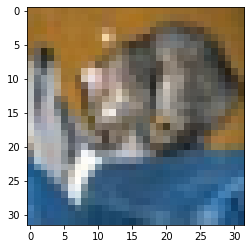

In [ ]:
plt.imshow(x_test[0])

In [ ]:
explanation = explainer.explain_instance(x_test[0].astype('double'), model.predict, top_labels=5, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

From plotting the results from the LIME explainer we can see that the part of the image above the yellow line is important for classification. This is expected as this is the part of the image displaying the cat and the part of that is removed does not contain the cat.

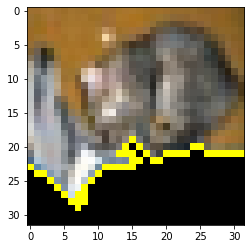

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp, mask))

We can also plot the 'pros' and 'cons' in green and red respectively. The red indicates that the blue part of the image is a con for cat clasification which makes sense as it is a blue color which would not be found on a cat.

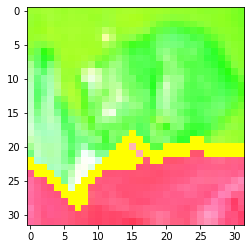

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))

Next I will use the Fast Gradient Sign method to perturn the image.

In [ ]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

Converting format of image so that it can be used in the create_adversarial_pattern function.

In [ ]:
img = tf.convert_to_tensor(x_test[0:1], dtype=tf.float32)
label = tf.convert_to_tensor(y_test[0:1], dtype=tf.float32)

perturbations = create_adversarial_pattern(img, label)

In the images below I show how the LIME visualiztion changes for epsilon value of 0, 0.0, 0.001, .0025, .005, .0075, .01. The increment of change is small so the visualization only changes for epsilon greater than .001. It also at this point that the classification changes from cat to dog. The visualization for these values of epsilon changes from the top portion of the image to the entirety of the image.

  0%|          | 0/1000 [00:00<?, ?it/s]

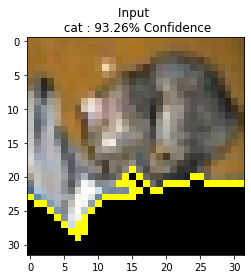

  0%|          | 0/1000 [00:00<?, ?it/s]

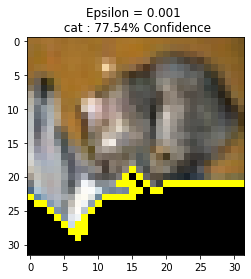

  0%|          | 0/1000 [00:00<?, ?it/s]

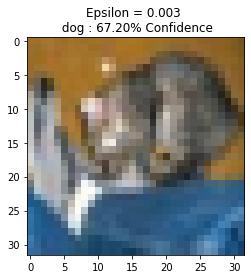

  0%|          | 0/1000 [00:00<?, ?it/s]

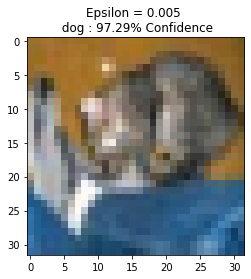

  0%|          | 0/1000 [00:00<?, ?it/s]

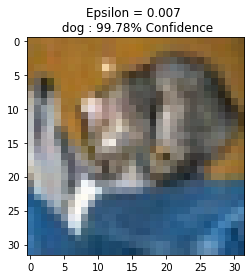

  0%|          | 0/1000 [00:00<?, ?it/s]

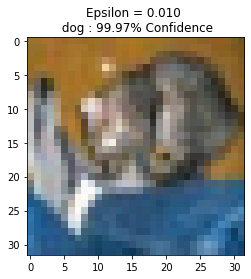

In [ ]:
(x_train, y_train), (x_test, y_test) = load_data()
epsilons = [0, 0.001, .0025, .005, .0075, .01]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                  for eps in epsilons]
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
          'dog', 'frog', 'horse', 'ship', 'truck']

for i, eps in enumerate(epsilons):
    adv_x = img + eps*perturbations
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    prediction = model.predict(adv_x)
    decoded = dict(zip(labels, prediction[0]))
    label, confidence = max(decoded.items(), key = operator.itemgetter(1))

    explanation = explainer.explain_instance(adv_x[0].numpy().astype('double'), model.predict, top_labels=5, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)

    plt.figure()
    plt.imshow(mark_boundaries(temp, mask))
    plt.title('{} \n {} : {:.2f}% Confidence'.format(descriptions[i], label, confidence*100))
    plt.show()

Next I visualize multiple values of epsilon for 10 images to see if there is a similar trend of changing LIME visualizations. Some images change from a smaller area of importance to a larger one while some do the oppisite. However it appears that most visualizations do not change and with the important area of the image being the whole image after perturbations at varying levels.

Also in some cases the model ignores parts of the image that contain the object being classified such as the automobile image. These reveal instances in which the model may be untrustworthy in it's predictions even without an attack/

  0%|          | 0/1000 [00:00<?, ?it/s]

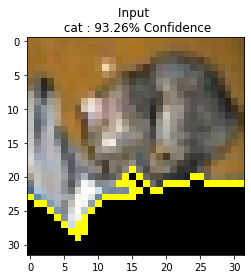

  0%|          | 0/1000 [00:00<?, ?it/s]

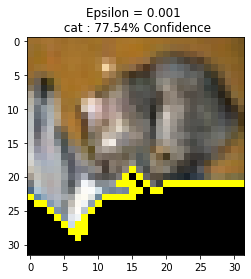

  0%|          | 0/1000 [00:00<?, ?it/s]

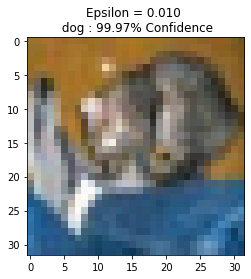

  0%|          | 0/1000 [00:00<?, ?it/s]

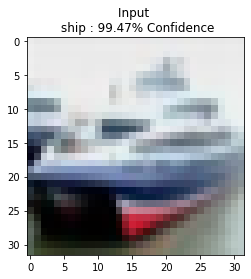

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


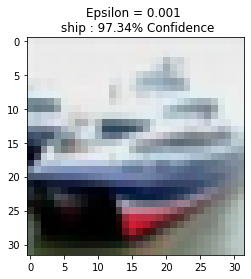

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


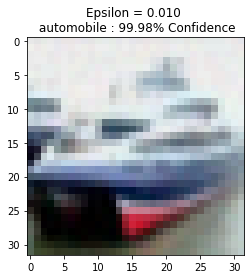

  0%|          | 0/1000 [00:00<?, ?it/s]

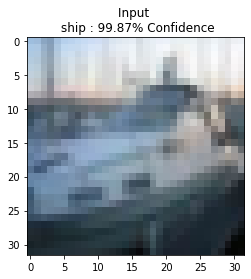

  0%|          | 0/1000 [00:00<?, ?it/s]

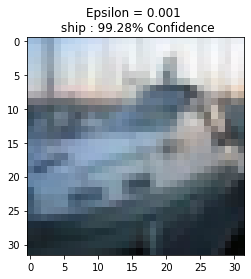

  0%|          | 0/1000 [00:00<?, ?it/s]

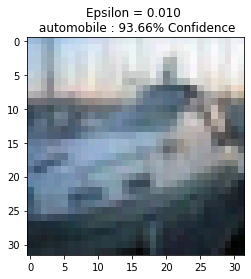

  0%|          | 0/1000 [00:00<?, ?it/s]

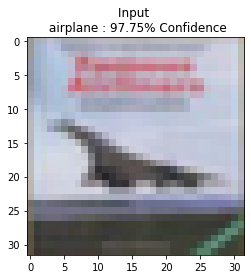

  0%|          | 0/1000 [00:00<?, ?it/s]

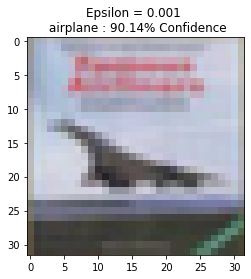

  0%|          | 0/1000 [00:00<?, ?it/s]

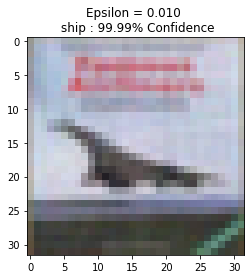

  0%|          | 0/1000 [00:00<?, ?it/s]

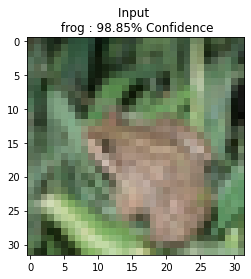

  0%|          | 0/1000 [00:00<?, ?it/s]

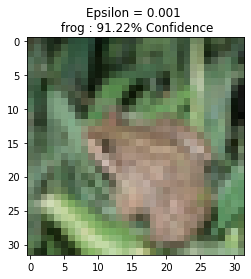

  0%|          | 0/1000 [00:00<?, ?it/s]

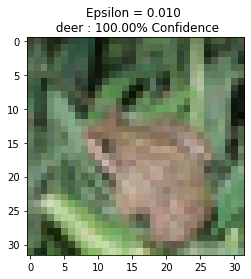

  0%|          | 0/1000 [00:00<?, ?it/s]

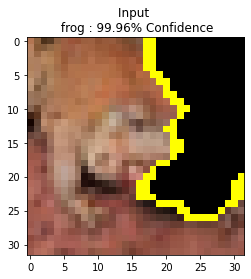

  0%|          | 0/1000 [00:00<?, ?it/s]

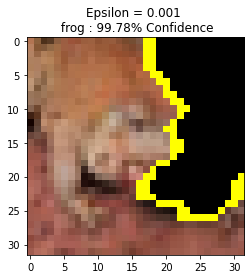

  0%|          | 0/1000 [00:00<?, ?it/s]

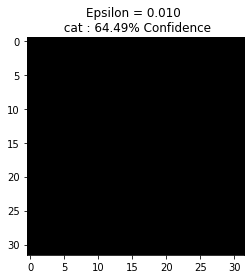

  0%|          | 0/1000 [00:00<?, ?it/s]

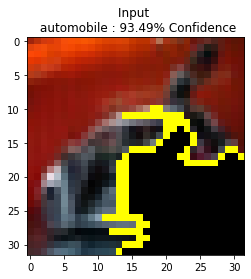

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


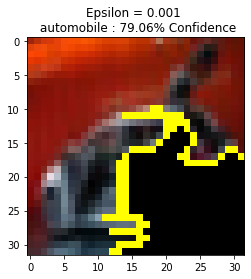

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


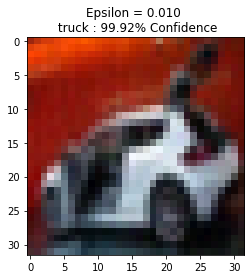

  0%|          | 0/1000 [00:00<?, ?it/s]

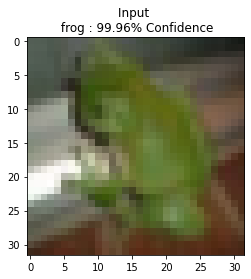

  0%|          | 0/1000 [00:00<?, ?it/s]

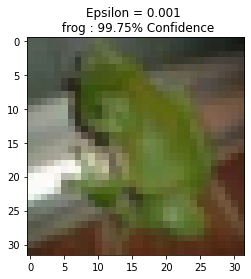

  0%|          | 0/1000 [00:00<?, ?it/s]

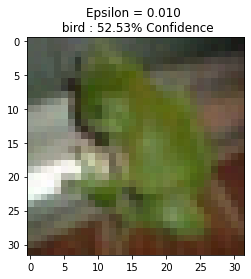

  0%|          | 0/1000 [00:00<?, ?it/s]

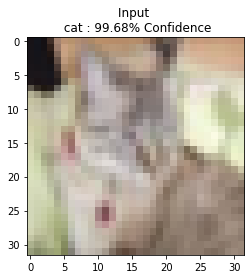

  0%|          | 0/1000 [00:00<?, ?it/s]

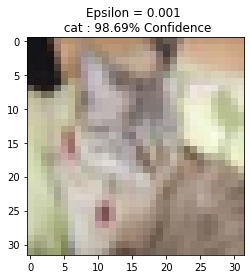

  0%|          | 0/1000 [00:00<?, ?it/s]

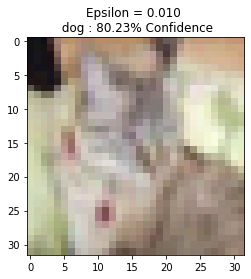

  0%|          | 0/1000 [00:00<?, ?it/s]

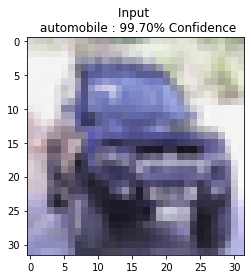

  0%|          | 0/1000 [00:00<?, ?it/s]

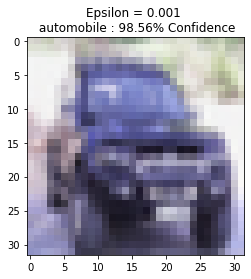

  0%|          | 0/1000 [00:00<?, ?it/s]

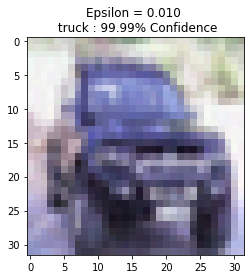

In [ ]:
for i in range(10):

  img = tf.convert_to_tensor(x_test[i:i+1], dtype=tf.float32)
  label = tf.convert_to_tensor(y_test[i:i+1], dtype=tf.float32)
  perturbations = create_adversarial_pattern(img, label)

  epsilons = [0, 0.001, 0.01]
  descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                  for eps in epsilons]

  for i, eps in enumerate(epsilons):
    adv_x = img + eps*perturbations
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    prediction = model.predict(adv_x)
    decoded = dict(zip(labels, prediction[0]))
    label, confidence = max(decoded.items(), key = operator.itemgetter(1))

    explanation = explainer.explain_instance(adv_x[0].numpy().astype('double'), model.predict, top_labels=5, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)

    plt.figure()
    plt.imshow(mark_boundaries(temp, mask))
    plt.title('{} \n {} : {:.2f}% Confidence'.format(descriptions[i], label, confidence*100))
    plt.show()

We can also visualize these same images using the 'pros' and 'cons' graphs which show the same phenomenon in a different way.

  0%|          | 0/1000 [00:00<?, ?it/s]

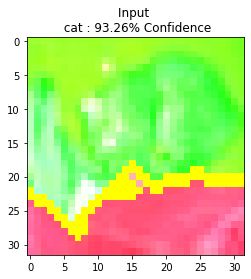

  0%|          | 0/1000 [00:00<?, ?it/s]

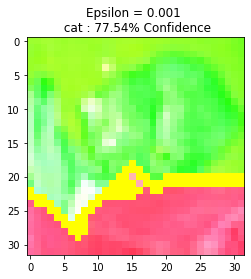

  0%|          | 0/1000 [00:00<?, ?it/s]

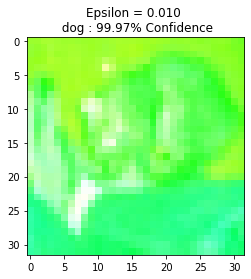

  0%|          | 0/1000 [00:00<?, ?it/s]

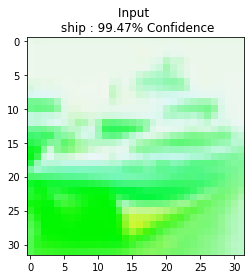

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


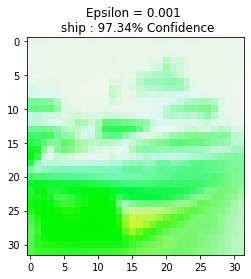

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


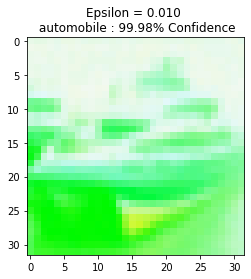

  0%|          | 0/1000 [00:00<?, ?it/s]

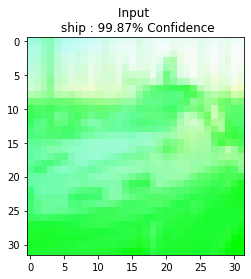

  0%|          | 0/1000 [00:00<?, ?it/s]

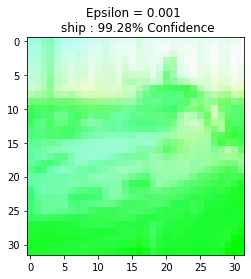

  0%|          | 0/1000 [00:00<?, ?it/s]

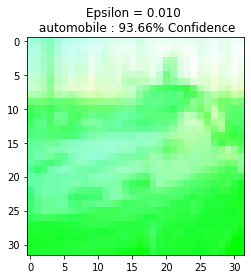

  0%|          | 0/1000 [00:00<?, ?it/s]

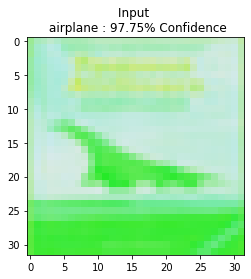

  0%|          | 0/1000 [00:00<?, ?it/s]

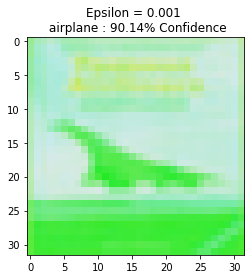

  0%|          | 0/1000 [00:00<?, ?it/s]

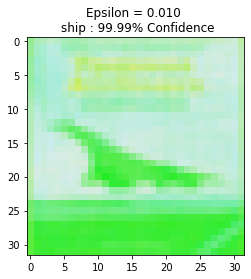

  0%|          | 0/1000 [00:00<?, ?it/s]

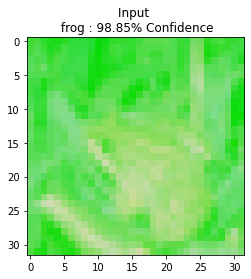

  0%|          | 0/1000 [00:00<?, ?it/s]

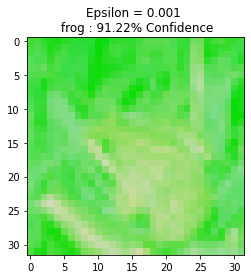

  0%|          | 0/1000 [00:00<?, ?it/s]

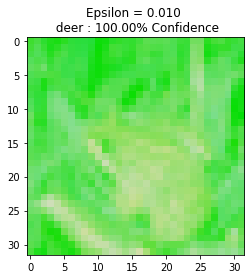

  0%|          | 0/1000 [00:00<?, ?it/s]

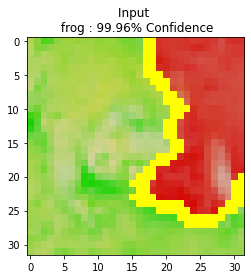

  0%|          | 0/1000 [00:00<?, ?it/s]

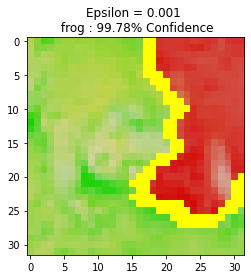

  0%|          | 0/1000 [00:00<?, ?it/s]

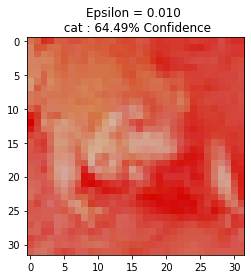

  0%|          | 0/1000 [00:00<?, ?it/s]

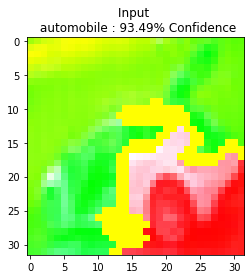

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


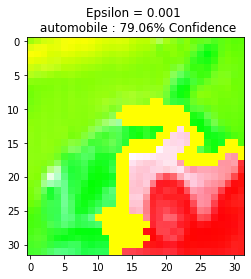

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


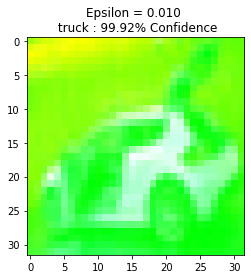

  0%|          | 0/1000 [00:00<?, ?it/s]

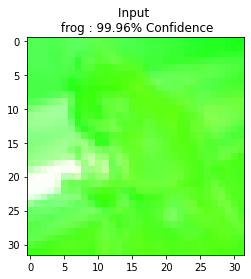

  0%|          | 0/1000 [00:00<?, ?it/s]

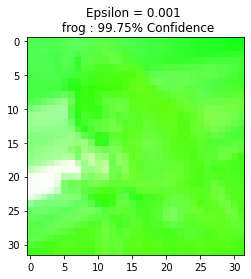

  0%|          | 0/1000 [00:00<?, ?it/s]

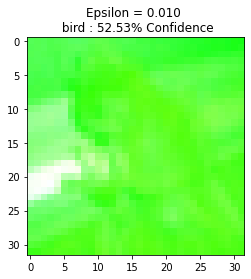

  0%|          | 0/1000 [00:00<?, ?it/s]

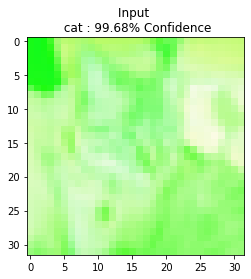

  0%|          | 0/1000 [00:00<?, ?it/s]

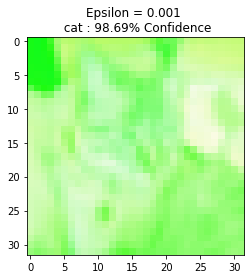

  0%|          | 0/1000 [00:00<?, ?it/s]

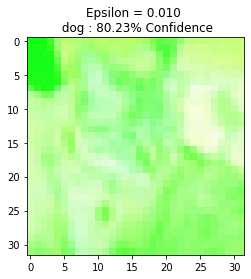

  0%|          | 0/1000 [00:00<?, ?it/s]

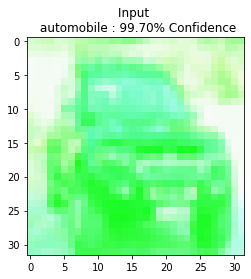

  0%|          | 0/1000 [00:00<?, ?it/s]

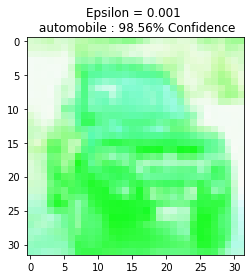

  0%|          | 0/1000 [00:00<?, ?it/s]

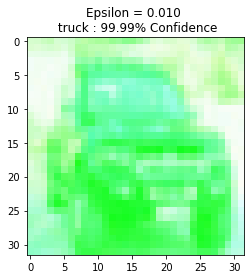

In [ ]:
for i in range(10):

  img = tf.convert_to_tensor(x_test[i:i+1], dtype=tf.float32)
  label = tf.convert_to_tensor(y_test[i:i+1], dtype=tf.float32)
  perturbations = create_adversarial_pattern(img, label)

  epsilons = [0, 0.001, 0.01]
  descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                  for eps in epsilons]

  for i, eps in enumerate(epsilons):
    adv_x = img + eps*perturbations
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    prediction = model.predict(adv_x)
    decoded = dict(zip(labels, prediction[0]))
    label, confidence = max(decoded.items(), key = operator.itemgetter(1))

    explanation = explainer.explain_instance(adv_x[0].numpy().astype('double'), model.predict, top_labels=5, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)

    plt.figure()
    plt.imshow(mark_boundaries(temp, mask))
    plt.title('{} \n {} : {:.2f}% Confidence'.format(descriptions[i], label, confidence*100))
    plt.show()

# Summary

Comparing LIME visualizaing of images with their perturbed counterparts do reveal differences in some but not all cases. It seems that a lot of images treat the whole image as important regardless of whether the image was altered. This may because the images do not contain many pixels and often the object of importance in the image is present in most of the pixels. It may be possible that this may not happen in larger images where there are more pixels and the object is not present in all the pixels.

However while this method does not reveal reasons for potential missclassification in all the images it does work to identify the problems in some images. Such as the image of the frog, where after the attack the network does not consider any of the image important. Also comparing the LIME visualizations does show that the models view the images differently even though I, as a human, do not see any difference between the images.